Accuracy: 0.9998

Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00    154283
      Benign       1.00      1.00      1.00    362015

    accuracy                           1.00    516298
   macro avg       1.00      1.00      1.00    516298
weighted avg       1.00      1.00      1.00    516298



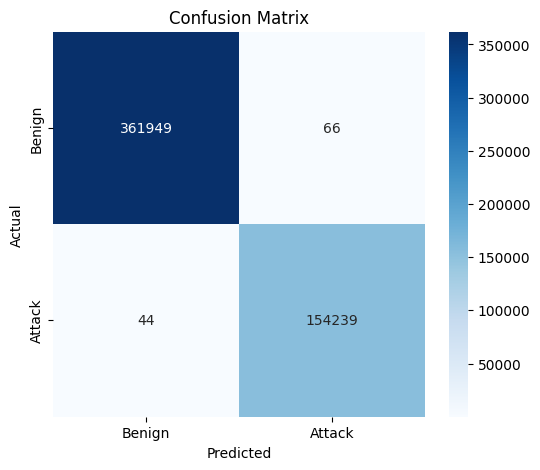

/var/folders/y5/6j_khfx9703159vgp4qxsqzw0000gn/T/ipykernel_59404/3333886101.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_scores, y=feat_names, palette='viridis')


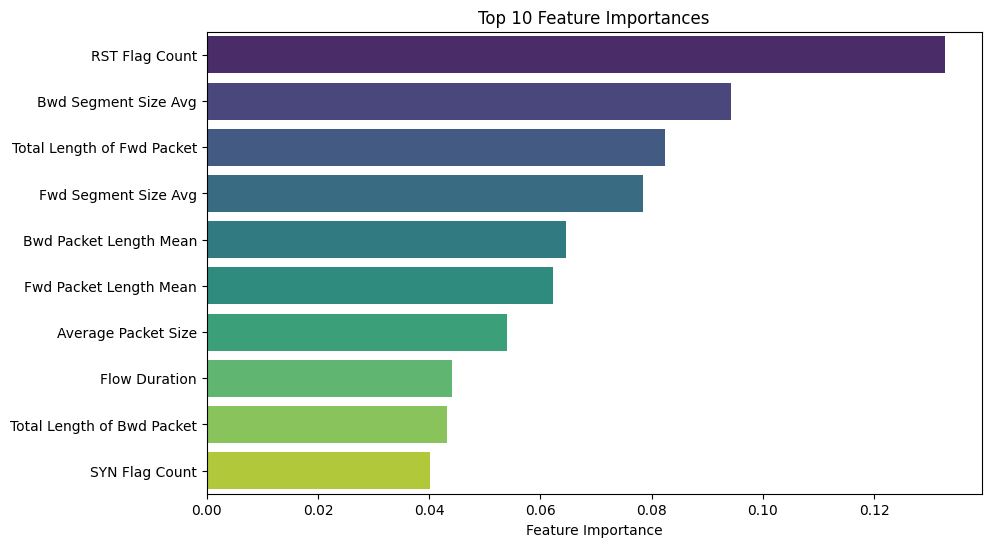

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned datasets
tuesday = pd.read_csv('tuesday_plus_cleaned.csv')
wednesday = pd.read_csv('wednesday_plus_cleaned.csv')
thursday = pd.read_csv('thursday_plus_cleaned.csv')
friday = pd.read_csv('friday_plus_cleaned.csv')

# Combine all days into one DataFrame
combined_df = pd.concat([tuesday, wednesday, thursday, friday], ignore_index=True)


# Columns to retain
selected_columns = [
    'Flow Duration',
    'Total Fwd Packet',
    'Total Bwd packets',
    'Total Length of Fwd Packet',
    'Total Length of Bwd Packet',
    'Fwd Packet Length Mean',
    'Bwd Packet Length Mean',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Bwd IAT Mean',
    'FIN Flag Count',
    'SYN Flag Count',
    'RST Flag Count',
    'PSH Flag Count',
    'ACK Flag Count',
    'URG Flag Count',
    'FWD Init Win Bytes',
    'Bwd Init Win Bytes',
    'Down/Up Ratio',
    'Average Packet Size',
    'Fwd Segment Size Avg',
    'Bwd Segment Size Avg',
    'Protocol',
    'Src Port',
    'Dst Port',
    'Label'
]

# Drop all other columns
combined_df = combined_df[selected_columns]

# Drop missing values
combined_df.dropna(inplace=True)

# Normalize labels to uppercase for consistent matching
combined_df['Label'] = combined_df['Label'].str.upper()

# Convert to binary labels: 'Benign' if exactly 'BENIGN', else 'Attack'
combined_df['Label'] = combined_df['Label'].apply(lambda x: 'Benign' if x == 'BENIGN' else 'Attack')

# Separate features and target
X = combined_df.drop('Label', axis=1)
y = combined_df['Label']

# Fake group IDs if actual flow/session ID is not present
groups = np.arange(len(X))

# Prevent data leakage using GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['Benign', 'Attack'])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Feature importance plot
importances = model.feature_importances_
feature_ranking = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)

# Prepare data for plot
feat_names = [name for name, _ in feature_ranking[:10]]
feat_scores = [score for _, score in feature_ranking[:10]]

plt.figure(figsize=(10,6))
sns.barplot(x=feat_scores, y=feat_names, palette='viridis')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.show()

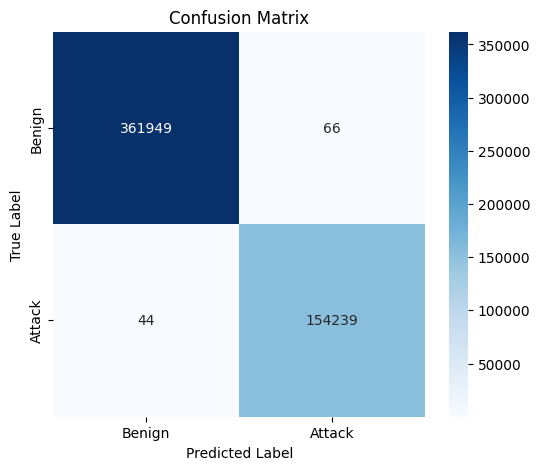

Confusion Matrix:
[[361949     66]
 [    44 154239]]


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_pred, labels=['Benign', 'Attack'])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Confusion Matrix:")
print(cm)


In [5]:
import joblib

joblib.dump(model, 'new_model.joblib')
print("✅ Model saved as final_model.joblib")




✅ Model saved as final_model.joblib


In [17]:
import pandas as pd
import numpy as np
import joblib
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# ----------------------
# 1. Load your test dataset
# ----------------------
df_test = pd.read_csv('tuesday_plus_cleaned.csv')

# Apply same preprocessing as during training:
df_test['Label'] = df_test['Label'].str.upper()
df_test['Label'] = df_test['Label'].apply(lambda x: 'Benign' if x == 'BENIGN' else 'Attack')

# Separate features and labels
y_test = df_test['Label']
X_test = df_test.drop(columns=['Label'])

# ----------------------
# 2. Load your trained models
# ----------------------
model1 = joblib.load('random_forest_model.joblib')  # model with full feature set
model2 = joblib.load('new_model.joblib')            # model with smaller feature set

# ----------------------
# 3. Define helper to align features
# ----------------------
def align_features(X, feature_names):
    """
    Ensure X has all columns from feature_names.
    Adds missing columns with zero, reorders columns exactly.
    """
    X_copy = X.copy()
    missing = [col for col in feature_names if col not in X_copy.columns]
    for col in missing:
        X_copy[col] = 0
    return X_copy[feature_names]

# ----------------------
# 4. Prepare test sets for each model
# ----------------------
X_test_model1 = align_features(X_test, model1.feature_names_in_)
X_test_model2 = align_features(X_test, model2.feature_names_in_)

# ----------------------
# 5. Encode true labels for numeric comparison
# ----------------------
le = LabelEncoder()
le.fit(y_test)
y_test_enc = le.transform(y_test)

# ----------------------
# 6. Evaluate Model 1
# ----------------------
start = time.time()
y_pred1 = model1.predict(X_test_model1)
time1 = time.time() - start

# If model predicts strings, encode them
if isinstance(y_pred1[0], str):
    y_pred1_enc = le.transform(y_pred1)
else:
    y_pred1_enc = y_pred1

print("=== Model 1 (Full Feature Set) ===")
print("Accuracy:", round(accuracy_score(y_test_enc, y_pred1_enc), 4))
print("Time to predict:", round(time1, 4), "s")
print(classification_report(y_test_enc, y_pred1_enc, target_names=le.classes_))

# ----------------------
# 7. Evaluate Model 2
# ----------------------
start = time.time()
y_pred2 = model2.predict(X_test_model2)
time2 = time.time() - start

if isinstance(y_pred2[0], str):
    y_pred2_enc = le.transform(y_pred2)
else:
    y_pred2_enc = y_pred2

print("\n=== Model 2 (Smaller Feature Set) ===")
print("Accuracy:", round(accuracy_score(y_test_enc, y_pred2_enc), 4))
print("Time to predict:", round(time2, 4), "s")
print(classification_report(y_test_enc, y_pred2_enc, target_names=le.classes_))

# ----------------------
# 8. Summary Comparison
# ----------------------
print("\n=== Summary Comparison ===")
print(f"Model 1 – Accuracy: {accuracy_score(y_test_enc, y_pred1_enc):.4f}, Predict Time: {time1:.4f}s")
print(f"Model 2 – Accuracy: {accuracy_score(y_test_enc, y_pred2_enc):.4f}, Predict Time: {time2:.4f}s")





=== Model 1 (Full Feature Set) ===
Accuracy: 1.0
Time to predict: 0.9944 s
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00      6972
      Benign       1.00      1.00      1.00    314071

    accuracy                           1.00    321043
   macro avg       1.00      1.00      1.00    321043
weighted avg       1.00      1.00      1.00    321043


=== Model 2 (Smaller Feature Set) ===
Accuracy: 1.0
Time to predict: 0.7823 s
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00      6972
      Benign       1.00      1.00      1.00    314071

    accuracy                           1.00    321043
   macro avg       1.00      1.00      1.00    321043
weighted avg       1.00      1.00      1.00    321043


=== Summary Comparison ===
Model 1 – Accuracy: 1.0000, Predict Time: 0.9944s
Model 2 – Accuracy: 1.0000, Predict Time: 0.7823s
